In [32]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
import os
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

path_sav_fig = f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/figure/"
if not os.path.isdir(path_sav_fig):
    os.mkdir(path_sav_fig)

key_Energy = "Erec"
key_tag = "evtType"
dir_map_tags = {0:"pES", 1:"eES"}

# Load Prediction Outputs
with np.load(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/predict_Combine.npz",
             allow_pickle=True) as f:
    dir_events = f["dir_events"].item()
    dir_train = f["dir_train"].item()


# Erec_max = max( dir_events[key_Energy] )
Erec_max = 12.5
# dir_diff_option_for_events = {"Without IBDp":dir_events}
dir_diff_option_for_events = {"With IBDp":dir_events}
print(dir_events[key_Energy])

[0.58030283 0.20648439 0.79750454 ... 0.18072918 0.37840062 0.38591179]


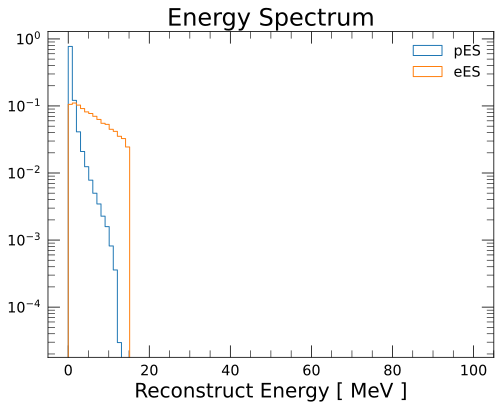

In [33]:
bins_equen= np.linspace(0, 100 ,100)
for tag in set(dir_events[f"{key_tag}(Truth)"]):
    plt.hist(dir_events[key_Energy][dir_events[f"{key_tag}(Truth)"]==tag],bins=bins_equen, histtype="step", label=tag,
             density=True)
plt.xlabel("Reconstruct Energy [ MeV ]")
plt.title("Energy Spectrum")
plt.semilogy()
plt.legend()


dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'evtType', 'R3', 'evtType(Truth)', 'PSD'])
dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'evtType', 'R3', 'evtType(Truth)', 'PSD'])
{'train': Counter({0: 21101, 1: 21101}), 'test': Counter({0: 334394, 1: 25791}), 'total': Counter({0: 355495, 1: 46892})}
dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'evtType', 'R3', 'evtType(Truth)'])
Counter({'pES': 21101, 'eES': 21101})


,pES,eES
Train,21101,21101
Test,334394,25791


No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

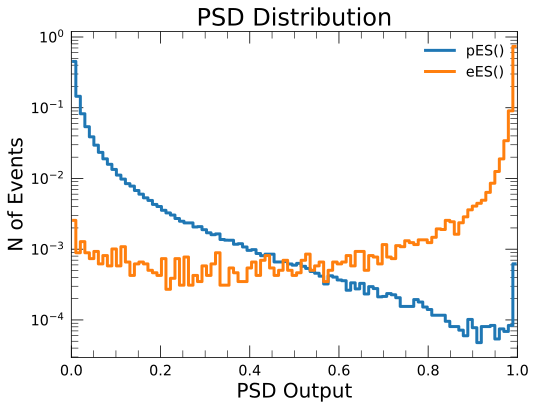

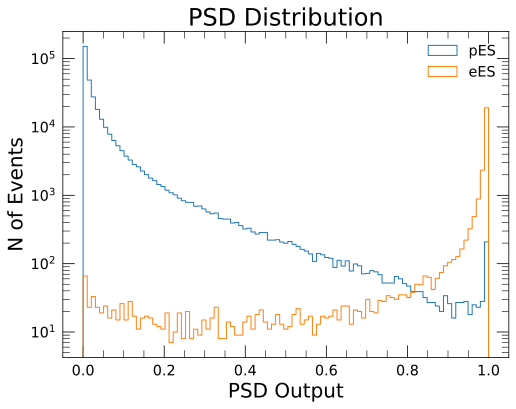

<Figure size 576x432 with 0 Axes>

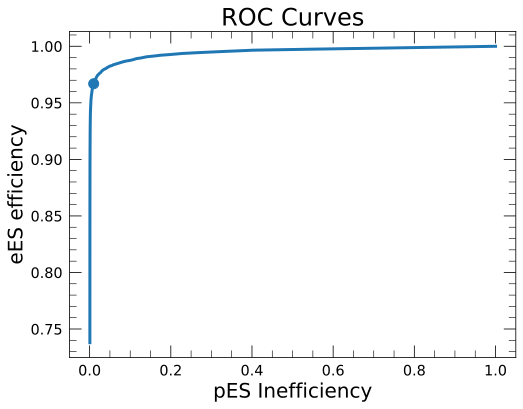

In [48]:
from importlib import reload
import DiscriminationTools
reload(DiscriminationTools)
from DiscriminationTools import  DiscriminationTools
discrimination_tool = DiscriminationTools(key_0="pES", key_1="eES")

print(dir_events.keys())

discrimination_tool.GetPredictionData("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/predict_Combine.npz")

discrimination_tool.PrintSamplesInformation()
discrimination_tool.GetPSDDistribution()
discrimination_tool.PlotROCCurves()
discrimination_tool.MaximumSignificance(v_bkg_ineff=np.linspace(0.01, 0.2,1000), condition="Total Samples", set_global_PSD_cut=True)




/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/DiscriminationTools.py:179: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
No handles with labels found to put in legend.


Test Samples,index,eES Eff.,pES Ineff.,(eES Residue)/(Total Residue),(pES Residue)/(Total Residue),PSD Cut,N_eES,N_pES
0,Total Samples,96.689 +- 0.083 %,1.000 +- 0.017 %,92.729 +- 0.12 %,7.271 +- 0.12 %,0.53,46892,355495
1,0.20 < Erec < 0.72 MeV,65.624 +- 0.84 %,0.908 +- 0.02 %,51.388 +- 0.79 %,48.612 +- 0.79 %,0.53,3166,216520
2,0.72 < Erec < 1.23 MeV,92.482 +- 0.49 %,0.701 +- 0.038 %,88.534 +- 0.58 %,11.466 +- 0.58 %,0.53,2877,49153
3,1.23 < Erec < 1.75 MeV,98.077 +- 0.26 %,0.637 +- 0.055 %,95.263 +- 0.4 %,4.737 +- 0.4 %,0.53,2750,21058
4,1.75 < Erec < 2.26 MeV,99.429 +- 0.15 %,0.839 +- 0.084 %,96.261 +- 0.37 %,3.739 +- 0.37 %,0.53,2573,11840
5,2.26 < Erec < 2.78 MeV,99.778 +- 0.095 %,1.115 +- 0.13 %,96.896 +- 0.34 %,3.104 +- 0.34 %,0.53,2459,7050
6,2.78 < Erec < 3.29 MeV,99.845 +- 0.081 %,1.441 +- 0.17 %,96.930 +- 0.35 %,3.070 +- 0.35 %,0.53,2339,5133
7,3.29 < Erec < 3.81 MeV,99.840 +- 0.085 %,1.963 +- 0.23 %,96.807 +- 0.37 %,3.193 +- 0.37 %,0.53,2225,3733
8,3.81 < Erec < 4.33 MeV,99.739 +- 0.11 %,2.427 +- 0.29 %,96.798 +- 0.38 %,3.202 +- 0.38 %,0.53,2128,2893
9,4.33 < Erec < 4.84 MeV,100.000 +- 0 %,2.352 +- 0.32 %,97.360 +- 0.36 %,2.640 +- 0.36 %,0.53,1918,2211


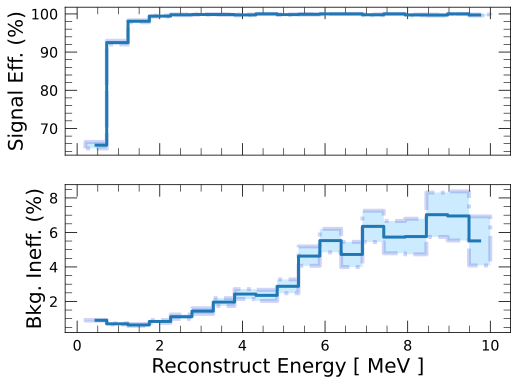

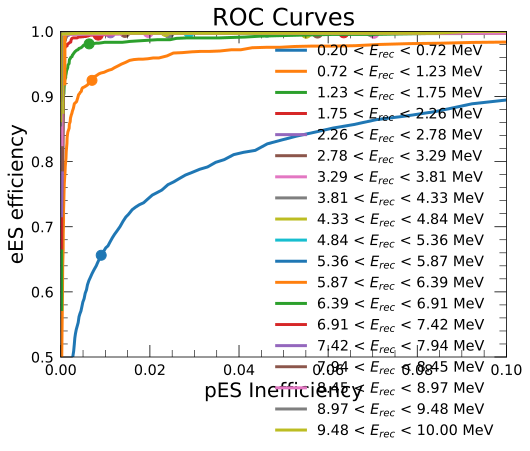

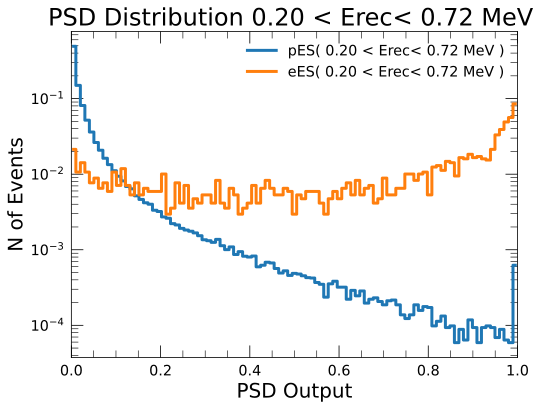

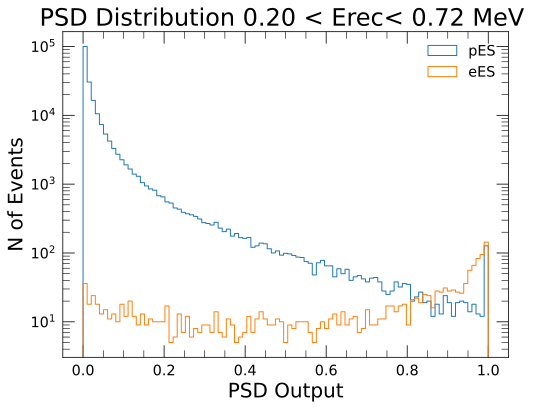

<Figure size 576x432 with 0 Axes>

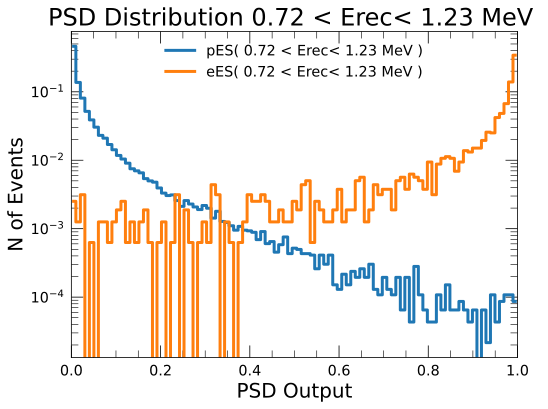

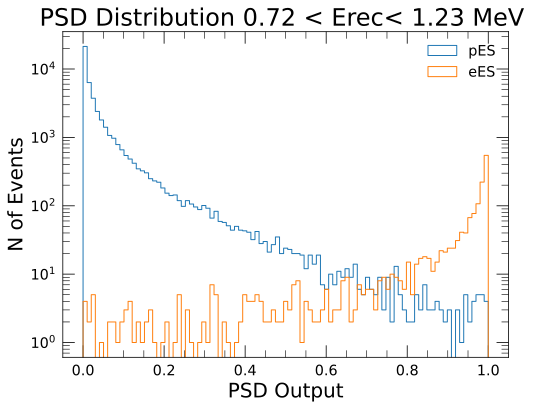

<Figure size 576x432 with 0 Axes>

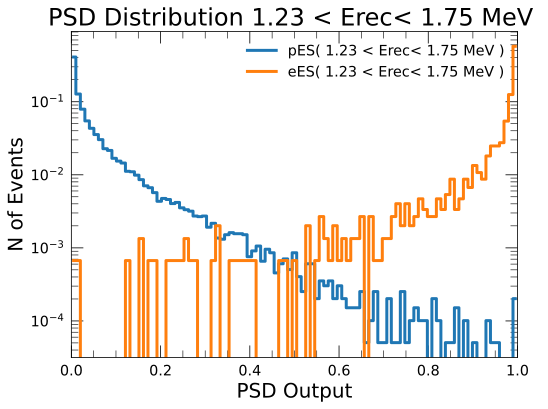

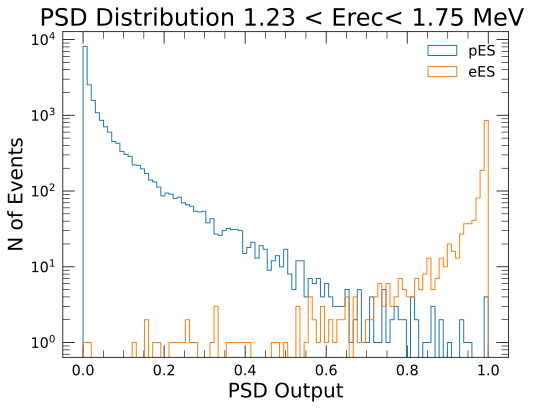

<Figure size 576x432 with 0 Axes>

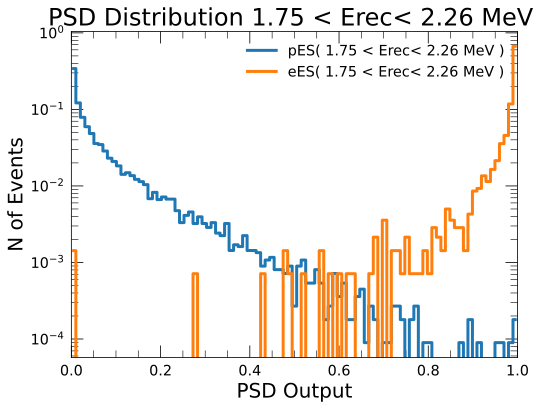

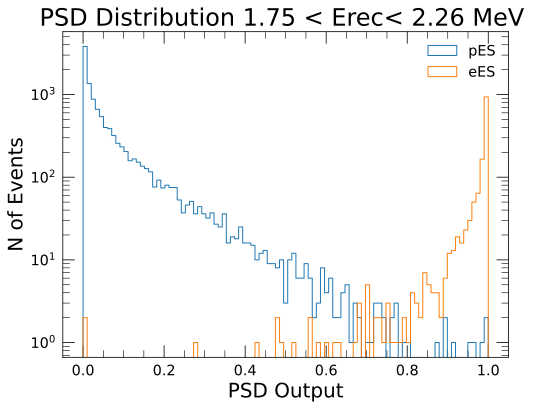

<Figure size 576x432 with 0 Axes>

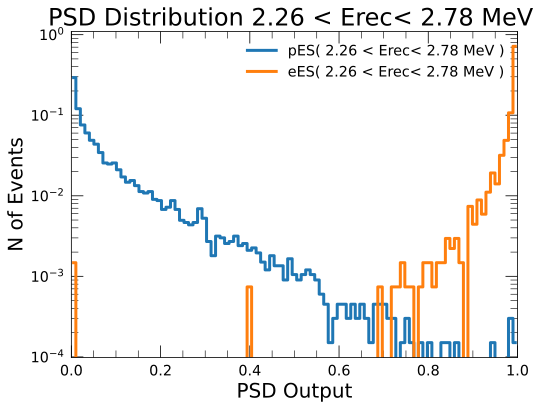

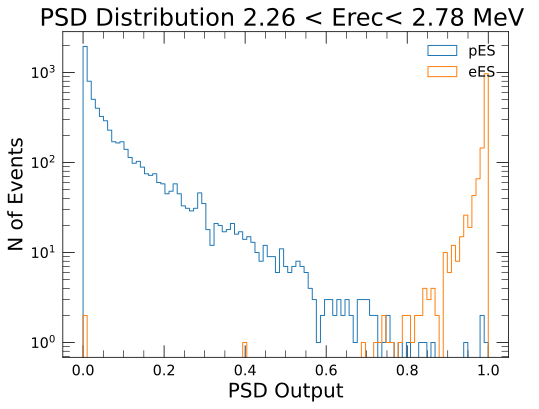

<Figure size 576x432 with 0 Axes>

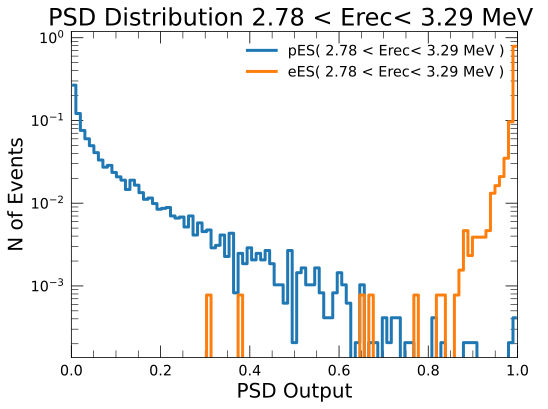

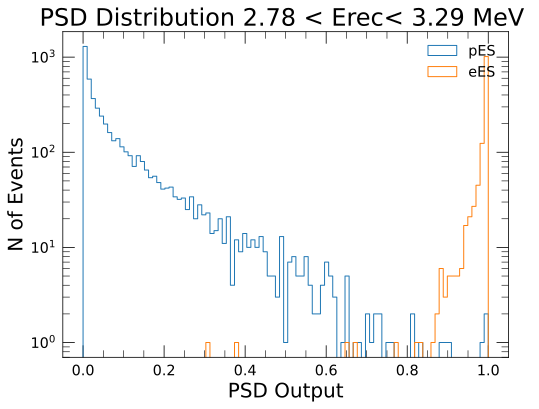

<Figure size 576x432 with 0 Axes>

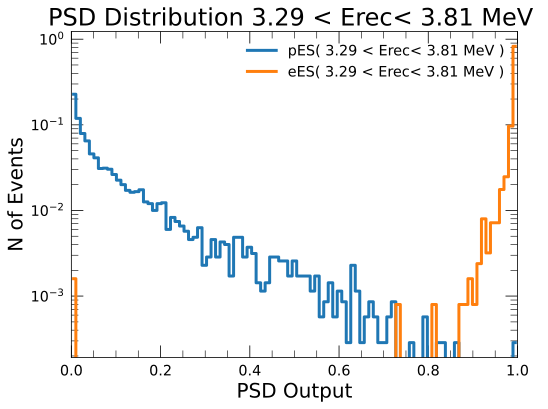

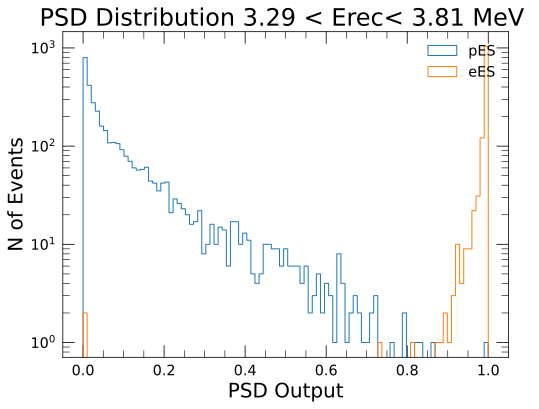

<Figure size 576x432 with 0 Axes>

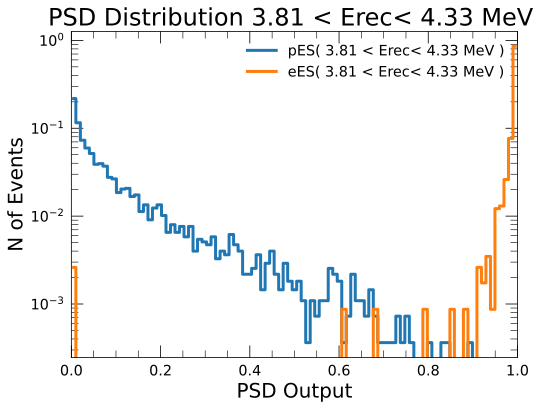

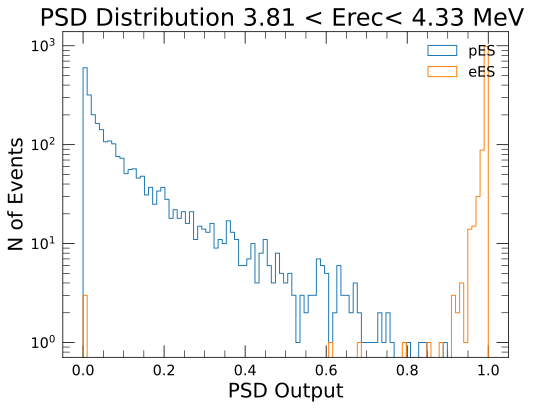

<Figure size 576x432 with 0 Axes>

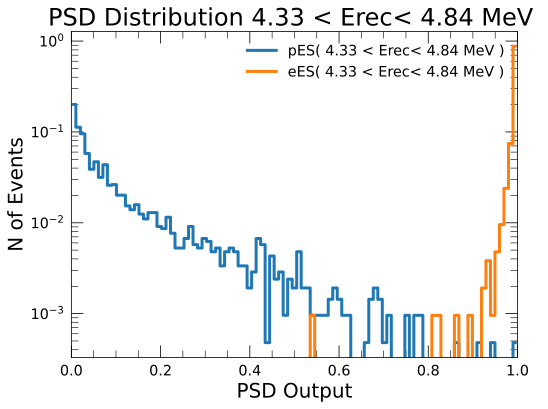

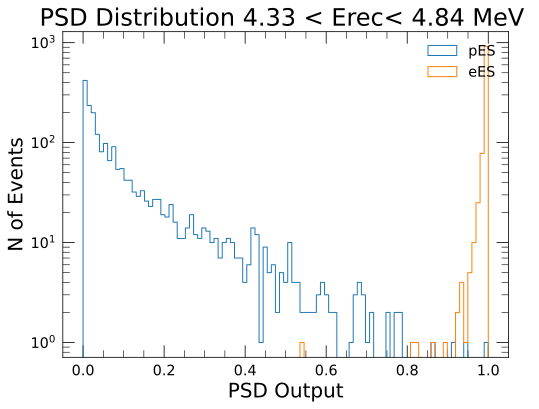

<Figure size 576x432 with 0 Axes>

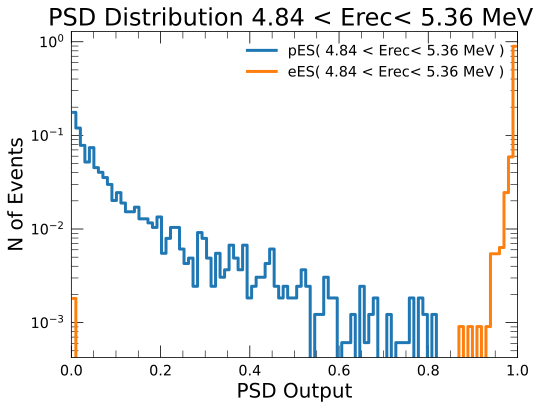

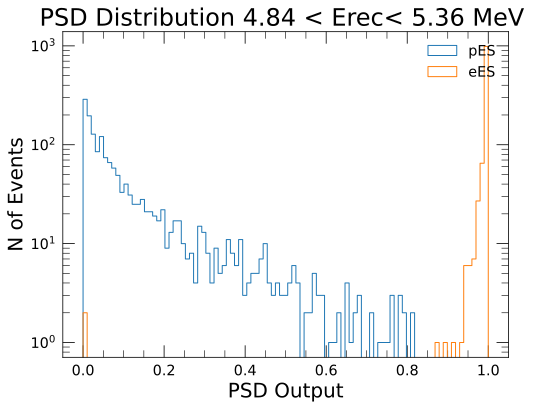

<Figure size 576x432 with 0 Axes>

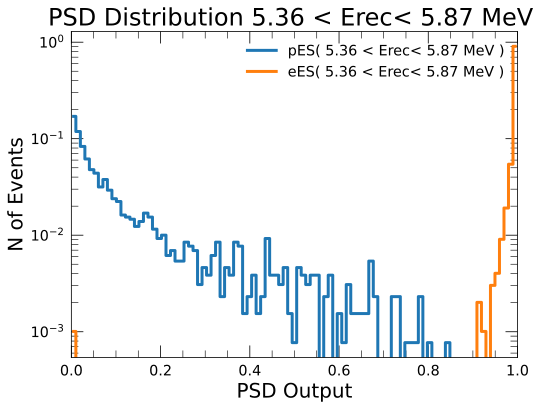

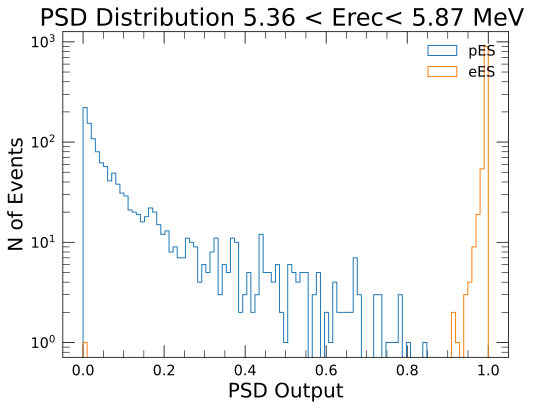

<Figure size 576x432 with 0 Axes>

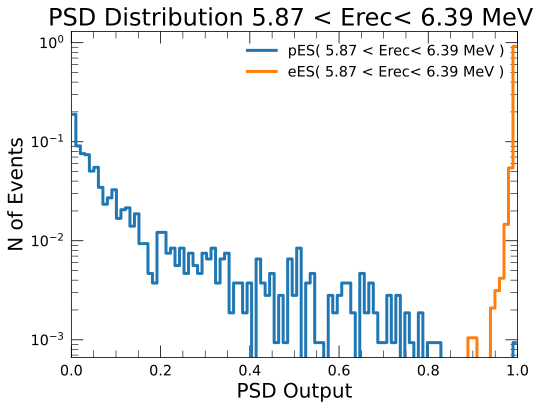

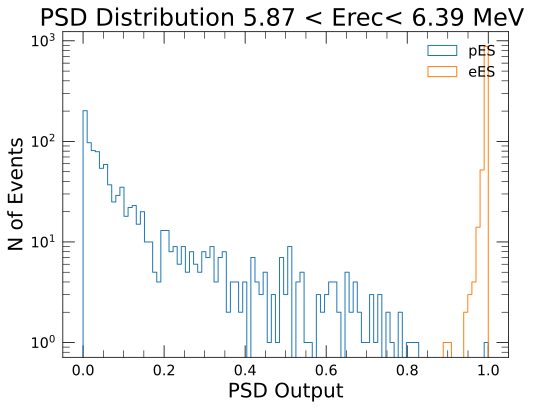

<Figure size 576x432 with 0 Axes>

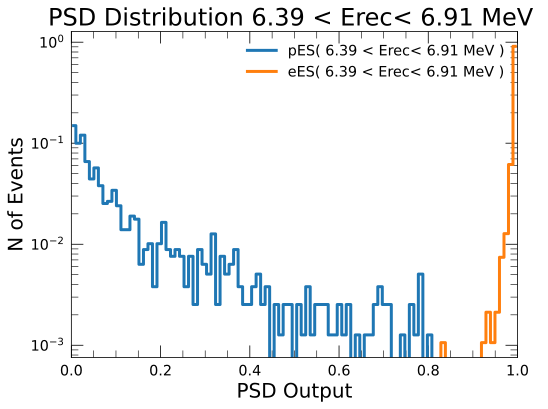

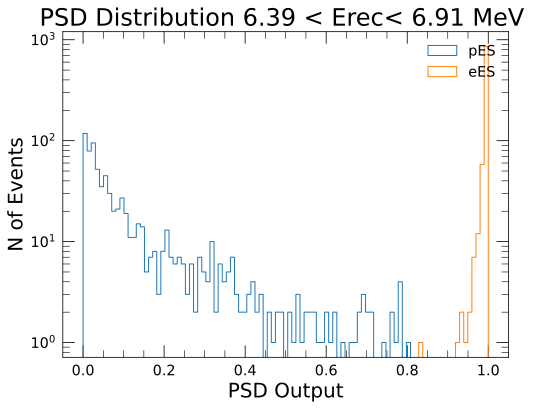

<Figure size 576x432 with 0 Axes>

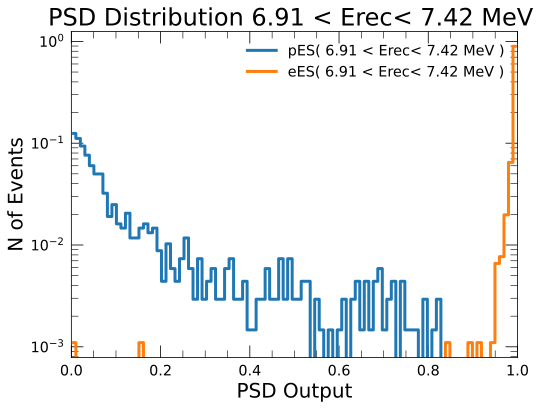

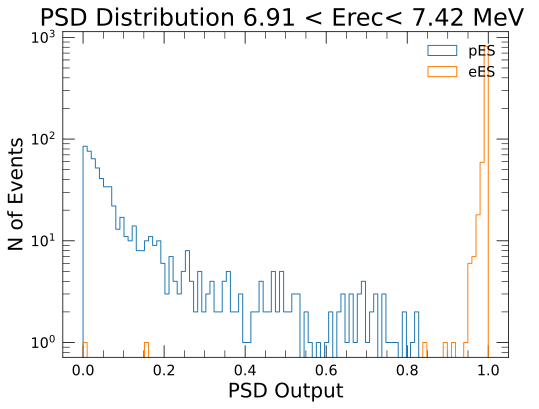

<Figure size 576x432 with 0 Axes>

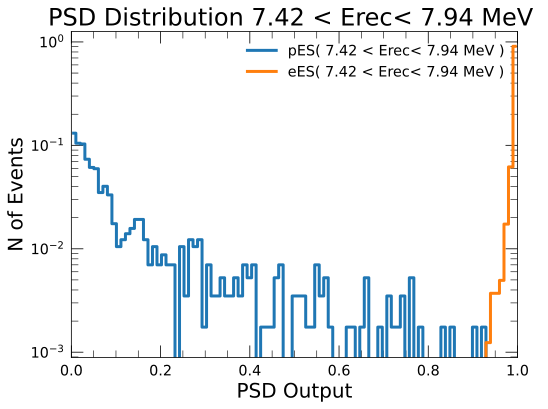

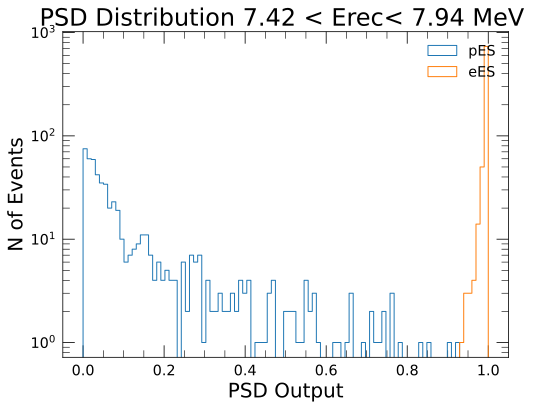

<Figure size 576x432 with 0 Axes>

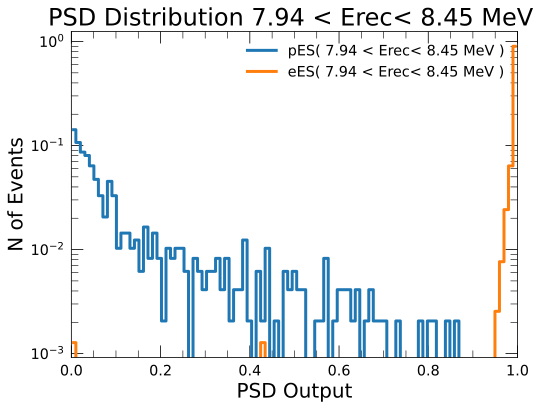

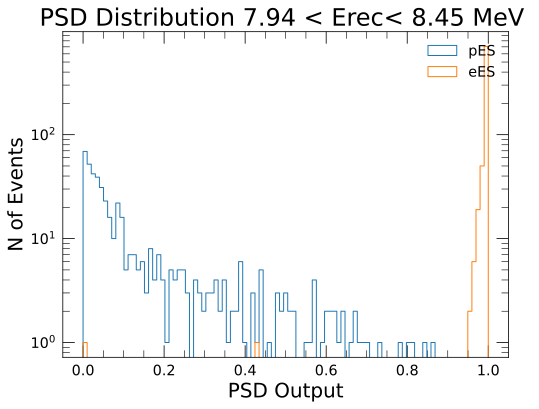

<Figure size 576x432 with 0 Axes>

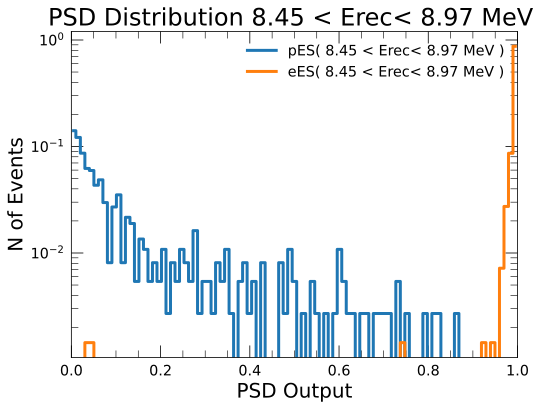

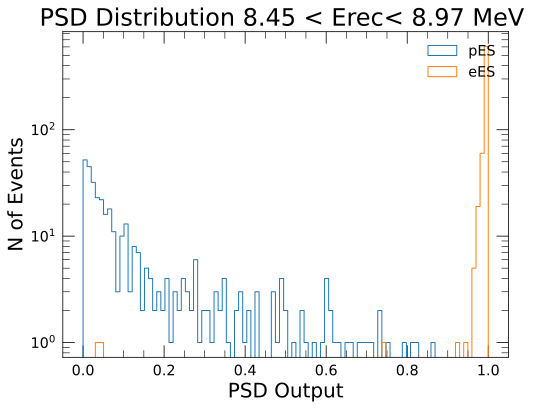

<Figure size 576x432 with 0 Axes>

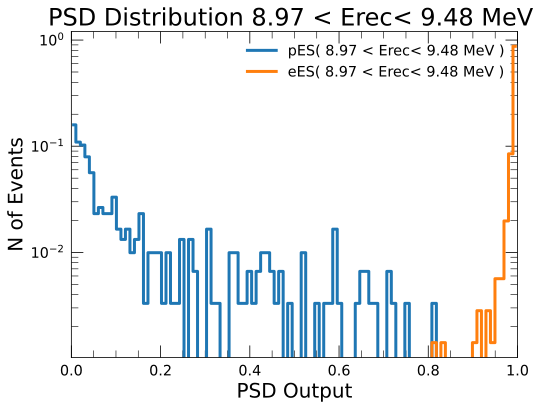

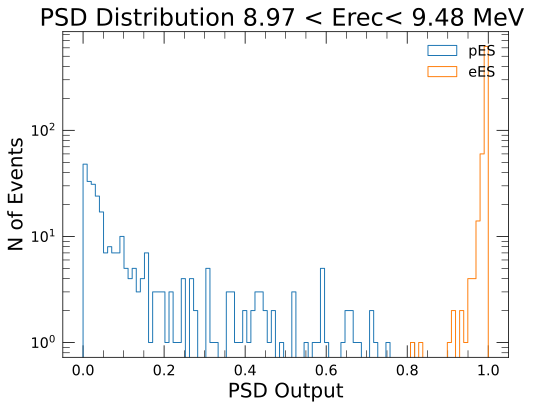

<Figure size 576x432 with 0 Axes>

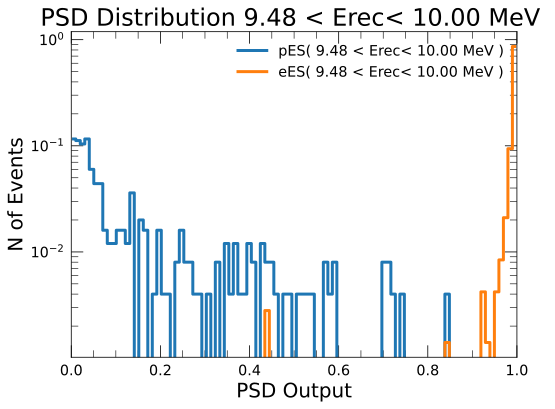

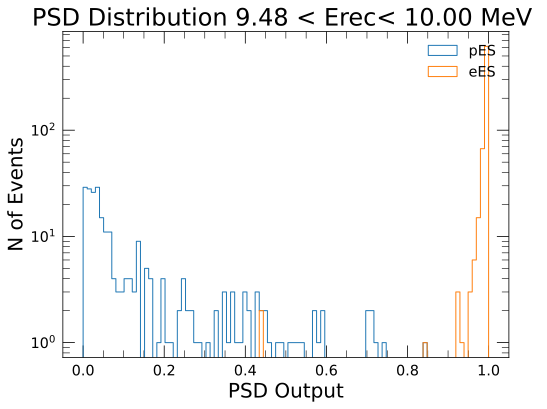

<Figure size 576x432 with 0 Axes>

In [49]:
fig, ax_eff = plt.subplots(2, sharex=True)
# discrimination_tool.global_PSD_cut = 0.9
discrimination_tool.PlotROCCurvesDiffEBins(bins_Energy=np.linspace(0.2, 10, 20), xlim=(0, 0.1), ylim=(0.5,1),
                                            max_significance=False,
                                           ax_eff=ax_eff)
discrimination_tool.PrintEffDataframe()